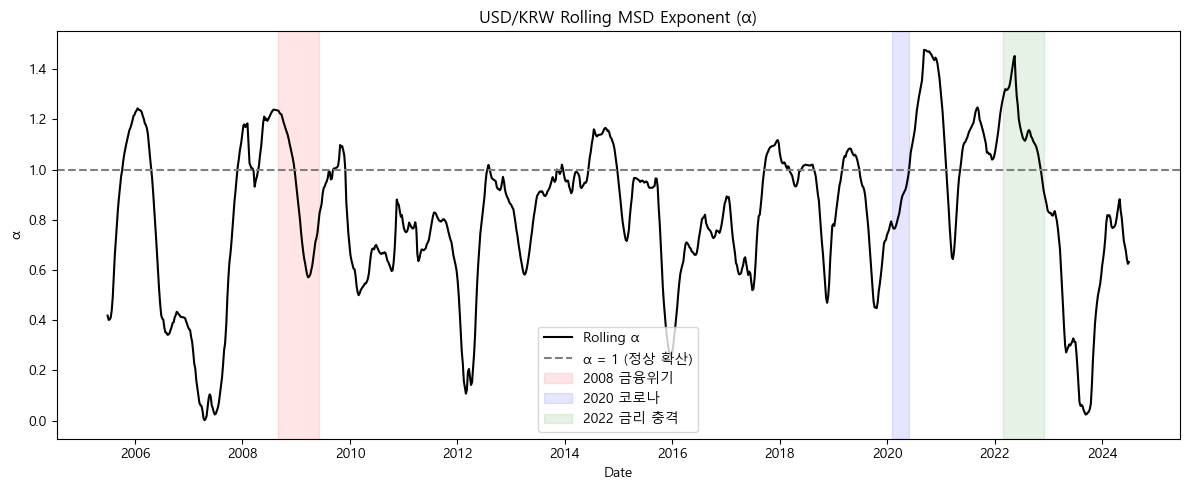

In [8]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# Windows 기본 한글 폰트
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font)

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False


# 경로 설정
PROJECT_ROOT = Path.cwd().parents[0]  # notebooks 기준
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from financial_physics.metrics.msd import rolling_alpha

# 데이터 로드
lp = pd.read_parquet(PROJECT_ROOT / "data" / "processed" / "log_prices.parquet")

# 자산 선택 (환율)
series = lp["KRW=X"].dropna()
x = series.values
dates = series.index

# rolling alpha 계산
centers, alphas = rolling_alpha(
    x,
    window=252,      # 1년
    step=5,          # 주 단위
    fit_range=(5, 120),
)

# centers를 날짜로 매핑
center_dates = dates[centers]

# 그래프
plt.figure(figsize=(12, 5))
plt.plot(center_dates, alphas, color='black', label="Rolling α")
plt.axhline(1.0, linestyle="--", color="gray", label="α = 1 (정상 확산)")

# 주요 위기 구간 표시
plt.axvspan(pd.Timestamp("2008-09-01"), pd.Timestamp("2009-06-01"),
            color="red", alpha=0.1, label="2008 금융위기")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-01"),
            color="blue", alpha=0.1, label="2020 코로나")
plt.axvspan(pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-01"),
            color="green", alpha=0.1, label="2022 금리 충격")

plt.title("USD/KRW Rolling MSD Exponent (α)")
plt.xlabel("Date")
plt.ylabel("α")
plt.legend()
plt.tight_layout()
plt.show()


컬럼: ['KRW=X', '^KS11', '^GSPC']


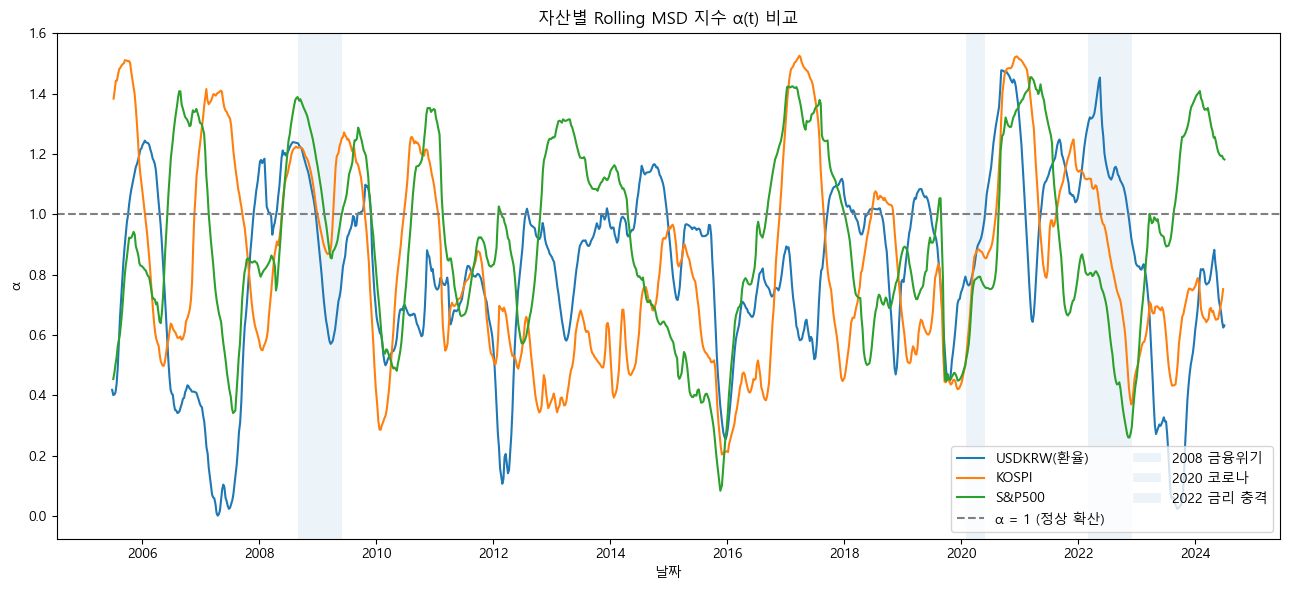

In [10]:
# import sys
# from pathlib import Path
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc

# ---- (1) 한글 폰트 설정 (Windows) ----
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font)
plt.rcParams["axes.unicode_minus"] = False

# ---- (2) import 경로 설정 ----
PROJECT_ROOT = Path.cwd().parents[0]  # notebooks 폴더 기준
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from financial_physics.metrics.msd import rolling_alpha

# ---- (3) 데이터 로드 ----
lp = pd.read_parquet(PROJECT_ROOT / "data" / "processed" / "log_prices.parquet")

# 컬럼이 실제로 뭔지 확인(한 번만)
print("컬럼:", list(lp.columns))

# ---- (4) 자산별 rolling alpha 계산 함수 ----
def compute_alpha_for_column(col_name: str, label: str, window=252, step=5, fit_range=(5, 120)):
    s = lp[col_name].dropna()
    x = s.values
    dates = s.index

    centers, alphas = rolling_alpha(
        x,
        window=window,
        step=step,
        fit_range=fit_range,
    )
    center_dates = dates[centers]
    out = pd.Series(alphas, index=center_dates, name=label)
    return out

# ---- (5) 자산별 alpha 시리즈 만들기 ----
# 네 데이터 기준 컬럼명이 보통: 'KRW=X', '^KS11', '^GSPC'
alpha_usdkrw = compute_alpha_for_column("KRW=X", "USDKRW(환율)")
alpha_kospi  = compute_alpha_for_column("^KS11", "KOSPI")
alpha_sp500  = compute_alpha_for_column("^GSPC", "S&P500")

# 날짜 정렬/정합(겹치는 구간만 비교하도록 outer join)
alpha_df = pd.concat([alpha_usdkrw, alpha_kospi, alpha_sp500], axis=1).sort_index()

# ---- (6) 그래프 ----
plt.figure(figsize=(13, 6))

plt.plot(alpha_usdkrw.index, alpha_usdkrw.values, label="USDKRW(환율)")
plt.plot(alpha_kospi.index,  alpha_kospi.values,  label="KOSPI")
plt.plot(alpha_sp500.index,  alpha_sp500.values,  label="S&P500")

plt.axhline(1.0, linestyle="--", color="gray", label="α = 1 (정상 확산)")

plt.axvspan(pd.Timestamp("2008-09-01"), pd.Timestamp("2009-06-01"), alpha=0.08, label="2008 금융위기")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-01"), alpha=0.08, label="2020 코로나")
plt.axvspan(pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-01"), alpha=0.08, label="2022 금리 충격")

plt.title("자산별 Rolling MSD 지수 α(t) 비교")
plt.xlabel("날짜")
plt.ylabel("α")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

